## ARIMA
- http://ucanalytics.com/blogs/time-series-decomposition-manufacturing-case-study-example-part-2/
- https://rpubs.com/zkajdan/316135

In [17]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/2330.TW.csv')
#df

In [18]:
df = df[~ df['Close'].isna()]

Populating the interactive namespace from numpy and matplotlib


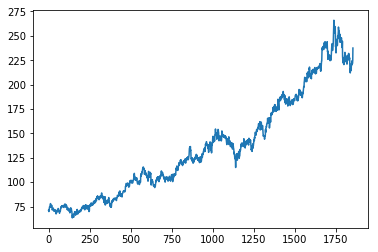

In [19]:
%pylab inline
df['Close'].plot(kind = 'line')

In [20]:
df.count()

Date         1851
Open         1851
High         1851
Low          1851
Close        1851
Adj Close    1851
Volume       1851
dtype: int64

In [21]:
trainset = df.iloc[0:1551,:]
testset  = df.iloc[1551: ,:]

In [22]:
trainset.shape

(1551, 7)

In [23]:
testset.shape

(300, 7)

In [24]:
trainset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1551,2017-04-25,190.5,192.0,189.5,192.0,179.272598,31932000.0
1552,2017-04-26,192.0,192.0,190.5,191.0,178.338898,29909000.0
1553,2017-04-27,192.0,193.0,190.5,193.0,180.206314,27940000.0
1554,2017-04-28,193.5,194.5,193.0,194.5,181.606888,34852000.0
1555,2017-05-02,198.5,199.0,195.5,196.5,183.474304,44119000.0


In [25]:
testset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1556,2017-05-03,198.0,198.5,197.0,198.0,184.874878,25723000.0
1557,2017-05-04,198.5,199.0,197.0,198.0,184.874878,22088000.0
1558,2017-05-05,197.0,198.5,197.0,197.5,184.408020,17036000.0
1559,2017-05-08,199.0,202.5,199.0,202.5,189.076569,36538000.0
1560,2017-05-09,205.5,207.0,203.5,203.5,190.010284,48077000.0


In [26]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [27]:
X = trainset.Close.values
differenced = difference(X, 365)

In [28]:
differenced

array([10.200005, 12.100006, 14.399994, ..., 53.      , 54.5     ,
       57.5     ])

In [29]:
len(differenced)

1186

In [30]:
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)

C:\Users\Vincent\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Vincent\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [31]:
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)

C:\Users\Vincent\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [32]:
len(forecast)

7

In [33]:
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 253.459276
Day 2: 309.512362
Day 3: 365.392878
Day 4: 420.535577
Day 5: 475.524856
Day 6: 530.168769
Day 7: 584.882477


In [34]:
testset[0 : 6]

,Date,Open,High,Low,Close,Adj Close,Volume
1556,2017-05-03,198.0,198.5,197.0,198.0,184.874878,25723000.0
1557,2017-05-04,198.5,199.0,197.0,198.0,184.874878,22088000.0
1558,2017-05-05,197.0,198.5,197.0,197.5,184.408020,17036000.0
1559,2017-05-08,199.0,202.5,199.0,202.5,189.076569,36538000.0
1560,2017-05-09,205.5,207.0,203.5,203.5,190.010284,48077000.0
1561,2017-05-10,204.0,206.0,204.0,205.5,191.877701,28312000.0


In [35]:
training_set = trainset[~ trainset['Close'].isna()].iloc[:, 4:5].values

In [36]:
training_set.shape

(1551, 1)

In [37]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [38]:
import numpy as np
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [39]:
# 最後加一個 dimension，因為我們只參考 Close 這個值
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [40]:
X_train.shape

(1491, 60, 1)

In [41]:
y_train.shape

(1491,)

## LSTM

In [42]:
# Importing the Keras libraries and packages
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

# 最後一層 LSTM，不用 return_sequences
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

C:\Users\Vincent\Anaconda3\envs\myenv\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [43]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epochs = 10
# epochs = 100
regressor.fit(X_train, y_train, epochs = epochs, batch_size = 32)

Epoch 1/10
1491/1491 [==============================] - 12s 8ms/step - loss: 0.0346
Epoch 2/10
1491/1491 [==============================] - 8s 5ms/step - loss: 0.0043
Epoch 3/10
1491/1491 [==============================] - 8s 5ms/step - loss: 0.0038
Epoch 4/10
1491/1491 [==============================] - 8s 5ms/step - loss: 0.0033
Epoch 5/10
1491/1491 [==============================] - 8s 5ms/step - loss: 0.0035
Epoch 6/10
1491/1491 [==============================] - 8s 6ms/step - loss: 0.0032
Epoch 7/10
1491/1491 [==============================] - 9s 6ms/step - loss: 0.0033
Epoch 8/10
1491/1491 [==============================] - 9s 6ms/step - loss: 0.0028
Epoch 9/10
1491/1491 [==============================] - 9s 6ms/step - loss: 0.0032
Epoch 10/10
1491/1491 [==============================] - 8s 5ms/step - loss: 0.0026


In [94]:
real_stock_price = testset.iloc[:,4:5].values

In [95]:
dataset_total = pandas.concat((trainset['Close'], testset['Close']), axis = 0)
dataset_total.tail(30)

1827    227.0
1828    226.0
1829    229.0
1830    232.0
1831    226.5
1832    231.0
1833    225.0
1834    226.0
1835    226.5
1836    227.5
1837    218.0
1838    214.5
1839    213.0
1840    212.0
1841    216.5
1842    214.0
1843    214.5
1844    216.0
1845    214.5
1846    217.0
1847    221.5
1848    222.0
1849    220.0
1850    220.5
1851    224.5
1852    223.5
1853    221.5
1854    223.0
1855    224.5
1856    237.5
Name: Close, dtype: float64

In [96]:
inputs = dataset_total[len(dataset_total) - len(testset['Close']) - 60:].values

In [97]:
inputs.shape

(360,)

In [98]:
# 最後加一個 dimension，因為我們只參考 Close 這個值
inputs = inputs.reshape(-1,1)

In [99]:
inputs.shape

(360, 1)

In [100]:
inputs = sc.transform(inputs)

In [101]:
len(inputs)

360

In [102]:
X_test = []
for i in range(60, 360):
    X_test.append(inputs[i-60:i, 0])

In [103]:
len(X_test)

300

In [104]:
X_test = np.array(X_test)

In [105]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [106]:
X_test.shape

(300, 60, 1)

In [107]:
predicted_stock_price = regressor.predict(X_test)

In [108]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

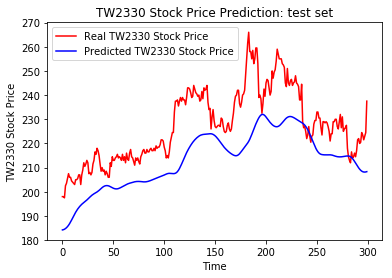

In [110]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price, color = 'red', label = 'Real TW2330 Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TW2330 Stock Price')
plt.title('TW2330 Stock Price Prediction: test set')
plt.xlabel('Time')
plt.ylabel('TW2330 Stock Price')
plt.legend()
plt.show()

In [111]:
predicted_stock_price2 = regressor.predict(X_train)
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price2)
real_stock_price2 = training_set

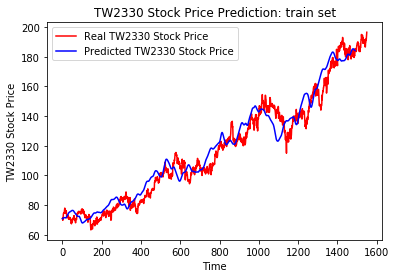

In [112]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price2, color = 'red', label = 'Real TW2330 Stock Price')
plt.plot(predicted_stock_price2, color = 'blue', label = 'Predicted TW2330 Stock Price')
plt.title('TW2330 Stock Price Prediction: train set')
plt.xlabel('Time')
plt.ylabel('TW2330 Stock Price')
plt.legend()
plt.show()

## 預測火鍋搜尋趨勢

In [113]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/hotpot.csv', skiprows= [0,1])

In [114]:
df.head()

,月,火鍋: (台灣)
0,2004-01,13
1,2004-02,10
2,2004-03,5
3,2004-04,5
4,2004-05,5


In [115]:
df.columns = ['月', '火鍋']

In [116]:
df.head()

,月,火鍋
0,2004-01,13
1,2004-02,10
2,2004-03,5
3,2004-04,5
4,2004-05,5


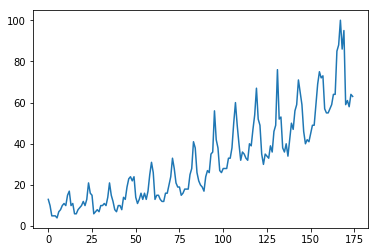

In [117]:
df['火鍋'].plot(kind='line')

In [118]:
len(df['火鍋'].values)

175

In [119]:
dataset = df['火鍋'].values

In [120]:
X_train = []
y_train = []
for i in range(7, 175):
    X_train.append(dataset[i-7:i])
    y_train.append(dataset[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [121]:
X_train.shape

(168, 7)

In [122]:
y_train.shape

(168,)

In [132]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [133]:
X_train.shape

(168, 7, 1)

In [134]:
# Importing the Keras libraries and packages
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [135]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epochs = 10
# epochs = 100
regressor.fit(X_train, y_train, epochs = epochs, batch_size = 2)

Epoch 1/10
168/168 [==============================] - 3s 15ms/step - loss: 1112.0173
Epoch 2/10
168/168 [==============================] - 0s 3ms/step - loss: 786.5984
Epoch 3/10
168/168 [==============================] - 0s 3ms/step - loss: 670.5353
Epoch 4/10
168/168 [==============================] - 0s 3ms/step - loss: 608.6797
Epoch 5/10
168/168 [==============================] - 0s 3ms/step - loss: 563.9724
Epoch 6/10
168/168 [==============================] - 0s 3ms/step - loss: 522.0893
Epoch 7/10
168/168 [==============================] - 0s 3ms/step - loss: 497.4959
Epoch 8/10
168/168 [==============================] - 0s 3ms/step - loss: 421.1478
Epoch 9/10
168/168 [==============================] - 0s 3ms/step - loss: 366.0543
Epoch 10/10
168/168 [==============================] - 0s 3ms/step - loss: 325.0364


In [136]:
predicted = regressor.predict(X_train)

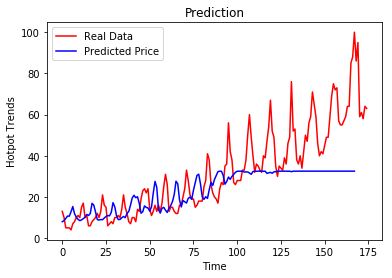

In [137]:
import matplotlib.pyplot as plt
plt.plot(dataset, color = 'red', label = 'Real Data')
plt.plot(predicted, color = 'blue', label = 'Predicted Price')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Hotpot Trends')
plt.legend()
plt.show()

## 使用LSTM 讓電腦自動寫文章 

In [44]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path, encoding='utf-8').read().lower()
print('Corpus length:', len(text))

606208/600901 [==============================] - 4s 6us/step
Corpus length: 600893


In [45]:
text[0]

'p'

In [46]:
# 查看有多少種字元
len(set(list(text)))

57

In [47]:
# 間隔取值：以下間隔為3
for i in range(0,10, 3):
    print(i)

0
3
6
9


In [48]:
# 從文章中取得序列長度
maxlen = 60

# 按步驟數進行隨機採樣
step = 3

# 保留句子的序列
sentences = []

# 保留下一個字元
next_chars = []

for i in range(0, len(text) - maxlen, step):
    # 根據step，每次取出 maxlen 的序列為 train data
    sentences.append(text[i: i + maxlen])
    # 取出序列的下一個字元當 targets
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

Number of sequences: 200278


In [49]:
# 產生詞彙表
chars = sorted(list(set(text)))
print(chars)
print('Unique characters:', len(chars))

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'æ', 'é', 'ë']
Unique characters: 57


In [50]:
# 利用字典對映 char 和索引 index
char_indices = dict((char, chars.index(char)) for char in chars)
print(char_indices)

{'0': 10, '?': 23, '1': 11, 'r': 44, 'w': 49, 'l': 38, 'x': 50, 'q': 43, 'y': 51, 'i': 35, '=': 22, 'n': 40, 'k': 37, ':': 20, '-': 8, ']': 25, ')': 6, '4': 14, '[': 24, '3': 13, 'u': 47, 'f': 32, ',': 7, '6': 16, 'c': 29, '5': 15, '!': 2, 's': 45, 'm': 39, ' ': 1, '2': 12, 'ä': 53, '.': 9, 'æ': 54, 'v': 48, 't': 46, '(': 5, '"': 3, '9': 19, '7': 17, 'h': 34, "'": 4, 'd': 30, '8': 18, '\n': 0, '_': 26, 'é': 55, 'o': 41, 'a': 27, 'g': 33, 'e': 31, 'j': 36, 'ë': 56, 'b': 28, 'p': 42, ';': 21, 'z': 52}


In [51]:
# x：訓練樣本
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)

In [52]:
x.shape

(200278, 60, 57)

In [53]:
# y：目標樣本
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

In [54]:
y.shape

(200278, 57)

In [55]:
for i, sentence in enumerate(sentences):        # 對每個句子
    for t, char in enumerate(sentence):         # 對每個詞
        x[i, t, char_indices[char]] = 1         # 將訓練樣本做one-hot
    y[i, char_indices[next_chars[i]]] = 1       # 將標籤做one-hot

In [56]:
text[0:60]

'preface\n\n\nsupposing that truth is a woman--what then? is the'

In [57]:
text[60]

'r'

In [58]:
text[0]

'p'

In [59]:
np.where(x[0][0] == True)

(array([42], dtype=int64),)

In [60]:
np.where(y[0] == True)

(array([44], dtype=int64),)

In [61]:
# 使用 LSTM 做下一個字元的預測

from keras import layers

model = keras.models.Sequential()
# 輸入為60 * 字串長度
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
# 以字元對應作為輸出
model.add(layers.Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [65]:
model.fit(x, y, batch_size=128, epochs=1)

Epoch 1/1
200278/200278 [==============================] - 278s 1ms/step - loss: 2.2592


In [68]:
#temperature 低：會出現重複率比較高但是部分結構比較真實的文章。 
#temperature 高：文章會比較有意義，但可能會發明一些新詞，詞的部分結構可能不完整，有的詞只有單詞的一半
#temperature=0.5：文章生成得比較好，在結構和隨機性保持平衡的情況下，產生比較好的句子。

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    # 根據temperature 計算
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    # 回傳多項式分布的概率
    probas = np.random.multinomial(1, preds, 1)
    # 回傳最大index
    return np.argmax(probas)

In [71]:
import random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]

In [73]:
generated_text

'lysis of will--i am ready to answer for this\ndiagnosis of th'

In [74]:
for i in range(400):
    sampled = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(generated_text):
        # 對字元做one-hot
        sampled[0, t, char_indices[char]] = 1

    # 計算預測的分佈值
    preds = model.predict(sampled, verbose=0)[0]
    # 輸出最大機率的字元 index
    next_index = sample(preds, 0.5)
    # 輸出字元
    next_char = chars[next_index]
    generated_text += next_char
    generated_text = generated_text[1:]

    sys.stdout.write(next_char)
    sys.stdout.flush()

e the sengal the fall a porise the heresemans and and and that his at ous the gare the the sosting mant of to se caly of the mat the beald deant the and congane the wor the hist poon the ence
the the reepar for moud the thes the and the man that with he the aris
the ard the thith in the and seand and
whes and to in in the sertally and care to taly and the and selt and moring the sees the sond cons

## Yelp Review
- https://github.com/Tony607/Yelp_review_generation/releases/download/V0.1/pre-trained.hdf5

### H5PY
- https://www.h5py.org/

In [76]:
! pip install h5py

In [83]:
import keras
from keras import layers
import sys
import numpy as np

# seed or initial text
text= 'this text file can be any text, as long as it contains text longer than maxlen defined below'

chars=['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']

# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)
maxlen=60
step=1

model = keras.models.Sequential()
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.load_weights("../pre-trained.hdf5")

optimizer = keras.optimizers.Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [84]:
len(chars)

95

In [85]:
len(text)

92

In [86]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def random_reviews():
    # sample a start index
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    # the initial sampled text with maxlen long
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with several reviews for you...')

    for temperature in [0.8]:
        sys.stdout.write(generated_text)

        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            # Turn each char to char index.
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            # Predict next char probabilities
            preds = model.predict(sampled, verbose=0)[0]
            # Add some randomness by sampling given probabilities.
            next_index = sample(preds, temperature)
            # Turn char index to char.
            next_char = chars[next_index]
            # Append char to generated text string
            generated_text += next_char
            # Pop the first char in generated text string.
            generated_text = generated_text[1:]
            # Print the new generated char.
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print(generated_text)

In [87]:
random_reviews()

Coming up with several reviews for you...
, as long as it contains text longer than maxlen defined belly.Servi

C:\Users\Vincent\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


ce was excellent as well. Hip and will come back<EOR>"
"<SOR>Went to this place twice in three days when you live in the area or anywhere. Lots of choices. Service is excellent. Love this place !!<EOR>"
"<SOR>This place is one of the best spots in town.  Great food, the best everything on the menu.  They have a great selection of micro brews, fast and friendly service. Pizza is so delicious and the options are extremely fresh. My second chocolate martini on a water was just right. I was beyond satisfied with the food. Thanks, David, Canes is a must.<EOR>"
"<SOR>Love this place! The comDavid, Canes is a must.<EOR>"
"<SOR>Love this place! The com


## 建立 Auto Encoders

### 建立 Encoders & Decoders

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

D:\Anaconda3\envs\myenv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [25]:
# encoding rate
784 / 32

24.5

In [7]:
# this is the size of our encoded representations
encoding_dim = 32 

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [8]:
encoder = Model(input_img, encoded)

In [9]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [10]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### 讀取 MNIST數據

In [11]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [12]:
x_train.shape

(60000, 28, 28)

In [15]:
x_test.shape

(10000, 28, 28)

In [16]:
np.prod(x_train.shape[1:])

784

In [17]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), 784 ))
x_test = x_test.reshape((len(x_test), 784))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### 訓練 Auto Encoders

In [19]:
epochs=10
# epochs=50
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0988 - val_loss: 0.0967
Epoch 2/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0971 - val_loss: 0.0953
Epoch 3/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0960 - val_loss: 0.0944
Epoch 4/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.0952 - val_loss: 0.0937
Epoch 5/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0948 - val_loss: 0.0933
Epoch 6/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0944 - val_loss: 0.0930
Epoch 7/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0942 - val_loss: 0.0929
Epoch 8/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0940 - val_loss: 0.0928
Epoch 9/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0938 - val_loss: 0.0925
Epoch

### 比較原圖與重建後的圖片

In [20]:
encoded_imgs = encoder.predict(x_test)

In [21]:
encoded_imgs.shape

(10000, 32)

In [22]:
decoded_imgs = decoder.predict(encoded_imgs)

In [23]:
decoded_imgs.shape

(10000, 784)

Populating the interactive namespace from numpy and matplotlib


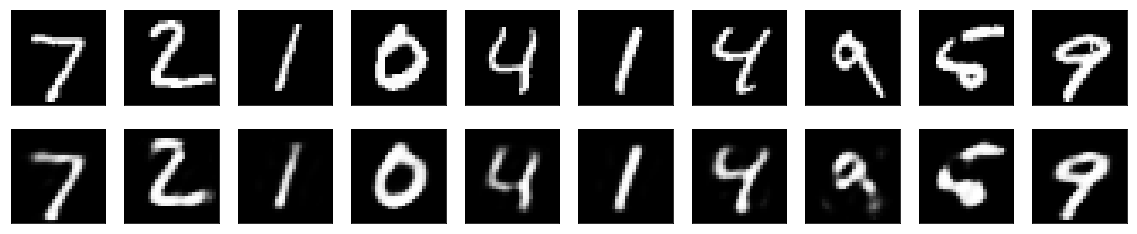

In [24]:
%pylab inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 讀取MNIST 數據

In [26]:
from  keras.datasets  import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [27]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [29]:
from keras.layers import Input, Dense
from keras.models import Model

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)

encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

epochs=10
# epochs=100
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.2442 - val_loss: 0.1631
Epoch 2/10
60000/60000 [==============================] - 3s 51us/step - loss: 0.1474 - val_loss: 0.1356
Epoch 3/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.1306 - val_loss: 0.1237
Epoch 4/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.1212 - val_loss: 0.1163
Epoch 5/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.1153 - val_loss: 0.1111
Epoch 6/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.1108 - val_loss: 0.1078
Epoch 7/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.1079 - val_loss: 0.1054
Epoch 8/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.1057 - val_loss: 0.1035
Epoch 9/10
60000/60000 [==============================] - 3s 51us/step - loss: 0.1039 - val_loss: 0.1019
Epoch

In [38]:
encoded_imgs = autoencoder.predict(x_test)
decoded_imgs = autoencoder.predict(encoded_imgs)

Populating the interactive namespace from numpy and matplotlib


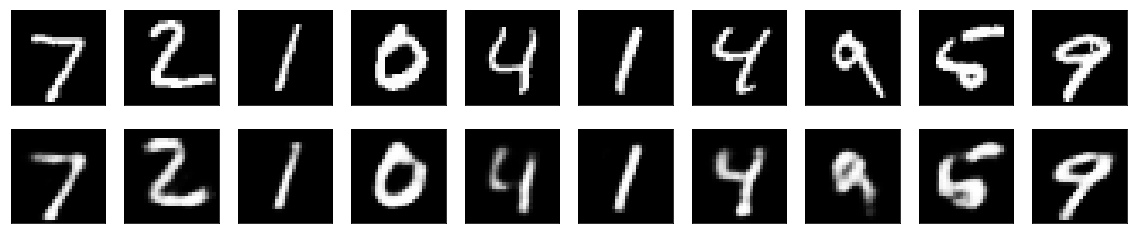

In [39]:
%pylab inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 使用Auto Encoders 建立推薦系統

In [90]:
import numpy
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from zipfile import ZipFile

def load_data():
    path = get_file('ml-100k.zip', origin='http://files.grouplens.org/datasets/movielens/ml-100k.zip')
    with ZipFile(path, 'r') as ml_zip:
        max_item_id  = -1
        train_history = {}
        with ml_zip.open('ml-100k/ua.base', 'r') as file:
            for line in file:
                user_id, item_id, rating, timestamp = line.decode('utf-8').rstrip().split('\t')
                if int(user_id) not in train_history:
                    train_history[int(user_id)] = [int(item_id)]
                else:
                    train_history[int(user_id)].append(int(item_id))

                if max_item_id < int(item_id):
                    max_item_id = int(item_id)

        test_history = {}
        with ml_zip.open('ml-100k/ua.test', 'r') as file:
            for line in file:
                user_id, item_id, rating, timestamp = line.decode('utf-8').rstrip().split('\t')
                if int(user_id) not in test_history:
                    test_history[int(user_id)] = [int(item_id)]
                else:
                    test_history[int(user_id)].append(int(item_id))
        
    max_item_id += 1 # item_id starts from 1
    train_users = list(train_history.keys())
    train_x = numpy.zeros((len(train_users), max_item_id), dtype=numpy.int32)
    for i, hist in enumerate(train_history.values()):
        mat = to_categorical(hist, max_item_id)
        train_x[i] = numpy.sum(mat, axis=0)

    test_users = list(test_history.keys())
    test_x = numpy.zeros((len(test_users), max_item_id), dtype=numpy.int32)
    for i, hist in enumerate(test_history.values()):
        mat = to_categorical(hist, max_item_id)
        test_x[i] = numpy.sum(mat, axis=0)

    return train_users, train_x, test_users, test_x

### 讀取數據


In [91]:
train_users, train_x, test_users, test_x= load_data()

In [92]:
import numpy as np
from scipy.sparse import csr_matrix, random
counts = csr_matrix(train_x, dtype=np.float64)

## 安裝 Implicit
- conda install -c conda-forge implicit

In [93]:
import implicit
from implicit.als import AlternatingLeastSquares

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(counts)

rows, cols = model.item_factors, model.user_factors

100%|████████████████████████████████████████| 15.0/15 [00:00<00:00, 36.49it/s]


In [94]:
rows.shape

(943, 50)

In [95]:
cols.shape

(1683, 50)

In [96]:
#train_users

In [97]:
user_items = counts.T.tocsr()

In [98]:
recs = model.recommend(5, user_items, N=10)

In [99]:
recs

[(221, 0.6201818),
 (801, 0.61606896),
 (200, 0.5428549),
 (542, 0.5419364),
 (441, 0.53657997),
 (616, 0.5212747),
 (803, 0.49577624),
 (787, 0.47370052),
 (6, 0.46770656),
 (327, 0.46330798)]

In [100]:
rows.shape

(943, 50)

In [101]:
cols.shape

(1683, 50)

In [104]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(cols)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.9999999 ,  0.40544447, ...,  0.04306765,
         0.1534507 ,  0.22473374],
       [ 0.        ,  0.40544447,  1.0000002 , ...,  0.04719759,
         0.21835904,  0.20742925],
       ...,
       [ 0.        ,  0.04306765,  0.04719759, ...,  0.99999994,
         0.02925921,  0.02865798],
       [ 0.        ,  0.1534507 ,  0.21835904, ...,  0.02925921,
         1.0000001 , -0.02720508],
       [ 0.        ,  0.22473374,  0.20742925, ...,  0.02865798,
        -0.02720508,  0.99999994]], dtype=float32)

In [108]:
cs[181].argsort()[::-1]

array([ 181,   50,  172, ..., 1293, 1671, 1433], dtype=int64)

## 偵測信用卡詐欺事件

### 引用套件

In [118]:
import pandas
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers

In [120]:
df  = pandas.read_csv('creditcard.csv')

In [122]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

### 資料探索

In [124]:
count_classes = pandas.value_counts(df['Class'], sort = True)
count_classes

0    284315
1       492
Name: Class, dtype: int64

### 檢視詐欺犯與正常人類別數量

Text(0,0.5,'Frequency')

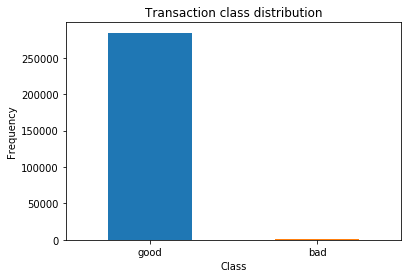

In [125]:
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), ['good', 'bad'])
plt.xlabel("Class")
plt.ylabel("Frequency")

### 檢視不同類別的交易金額是否有差別

In [126]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

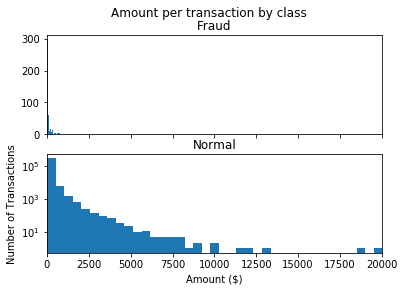

In [127]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

### 檢視交易時間是否有差別

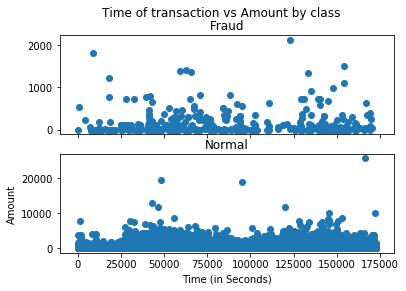

In [128]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### 資料預處理

In [129]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [131]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


### 建立訓練與測試資料集

In [136]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']

X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test  = X_test.values

### 建立 Auto Encoders

In [137]:
input_dim = X_train.shape[1]
print(input_dim)
encoding_dim = 14

29


In [138]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(7, activation="relu")(encoder)

decoder = Dense(7, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [139]:
nb_epoch   = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer])

Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - ETA: 26:10 - loss: 1.0457 - acc: 0.09 - ETA: 27s - loss: 1.2437 - acc: 0.0228 - ETA: 15s - loss: 1.1040 - acc: 0.05 - ETA: 11s - loss: 1.0563 - acc: 0.11 - ETA: 9s - loss: 1.0425 - acc: 0.1697 - ETA: 8s - loss: 1.0187 - acc: 0.217 - ETA: 7s - loss: 0.9990 - acc: 0.254 - ETA: 7s - loss: 0.9827 - acc: 0.282 - ETA: 6s - loss: 0.9780 - acc: 0.304 - ETA: 6s - loss: 0.9729 - acc: 0.320 - ETA: 6s - loss: 1.0571 - acc: 0.334 - ETA: 6s - loss: 1.0355 - acc: 0.348 - ETA: 5s - loss: 1.0232 - acc: 0.356 - ETA: 5s - loss: 1.0170 - acc: 0.369 - ETA: 5s - loss: 1.0142 - acc: 0.377 - ETA: 5s - loss: 1.0070 - acc: 0.386 - ETA: 5s - loss: 1.0076 - acc: 0.395 - ETA: 5s - loss: 1.0156 - acc: 0.404 - ETA: 5s - loss: 1.0044 - acc: 0.411 - ETA: 4s - loss: 0.9978 - acc: 0.417 - ETA: 4s - loss: 0.9878 - acc: 0.424 - ETA: 4s - loss: 0.9764 - acc: 0.429 - ETA: 4s - loss: 0.9701 - acc: 0.435 - ETA: 4s - 

227451/227451 [==============================] - ETA: 1:11 - loss: 0.4647 - acc: 0.781 - ETA: 6s - loss: 0.6903 - acc: 0.6641  - ETA: 5s - loss: 0.6660 - acc: 0.666 - ETA: 5s - loss: 0.6767 - acc: 0.669 - ETA: 5s - loss: 0.6538 - acc: 0.671 - ETA: 5s - loss: 0.6565 - acc: 0.670 - ETA: 5s - loss: 0.6807 - acc: 0.669 - ETA: 4s - loss: 0.6793 - acc: 0.668 - ETA: 4s - loss: 0.6689 - acc: 0.669 - ETA: 4s - loss: 0.6772 - acc: 0.670 - ETA: 4s - loss: 0.6804 - acc: 0.671 - ETA: 4s - loss: 0.6834 - acc: 0.668 - ETA: 4s - loss: 0.6948 - acc: 0.668 - ETA: 4s - loss: 0.7038 - acc: 0.669 - ETA: 4s - loss: 0.7025 - acc: 0.667 - ETA: 4s - loss: 0.7091 - acc: 0.668 - ETA: 4s - loss: 0.7108 - acc: 0.668 - ETA: 4s - loss: 0.7097 - acc: 0.668 - ETA: 4s - loss: 0.7095 - acc: 0.668 - ETA: 4s - loss: 0.7111 - acc: 0.667 - ETA: 4s - loss: 0.7085 - acc: 0.667 - ETA: 4s - loss: 0.7069 - acc: 0.667 - ETA: 4s - loss: 0.7051 - acc: 0.667 - ETA: 4s - loss: 0.6995 - acc: 0.667 - ETA: 4s - loss: 0.7023 - acc: 0.667

227451/227451 [==============================] - ETA: 2:07 - loss: 0.6460 - acc: 0.687 - ETA: 7s - loss: 0.6219 - acc: 0.6696  - ETA: 6s - loss: 0.6442 - acc: 0.677 - ETA: 6s - loss: 0.6769 - acc: 0.672 - ETA: 5s - loss: 0.6737 - acc: 0.674 - ETA: 5s - loss: 0.7381 - acc: 0.674 - ETA: 5s - loss: 0.7391 - acc: 0.675 - ETA: 5s - loss: 0.7209 - acc: 0.674 - ETA: 5s - loss: 0.7127 - acc: 0.674 - ETA: 5s - loss: 0.7148 - acc: 0.672 - ETA: 4s - loss: 0.7120 - acc: 0.673 - ETA: 4s - loss: 0.7074 - acc: 0.672 - ETA: 4s - loss: 0.6990 - acc: 0.674 - ETA: 4s - loss: 0.7090 - acc: 0.675 - ETA: 4s - loss: 0.7082 - acc: 0.675 - ETA: 4s - loss: 0.7059 - acc: 0.674 - ETA: 4s - loss: 0.7058 - acc: 0.675 - ETA: 4s - loss: 0.7038 - acc: 0.674 - ETA: 4s - loss: 0.7049 - acc: 0.674 - ETA: 4s - loss: 0.7037 - acc: 0.673 - ETA: 4s - loss: 0.7034 - acc: 0.673 - ETA: 4s - loss: 0.7040 - acc: 0.674 - ETA: 4s - loss: 0.7018 - acc: 0.674 - ETA: 4s - loss: 0.6982 - acc: 0.674 - ETA: 4s - loss: 0.6973 - acc: 0.673

In [140]:
autoencoder = load_model('model.h5')

### 評估模型

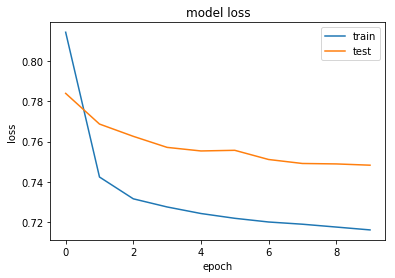

In [142]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [143]:
predictions = autoencoder.predict(X_test)

In [145]:
predictions.shape

(56962, 29)

In [147]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
43428,81.404245,1
49906,0.831528,0
29474,0.226130,0
276481,0.398445,0
278846,0.171506,0


In [148]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [152]:
#error_df.reconstruction_error

### 繪製ROC Curve

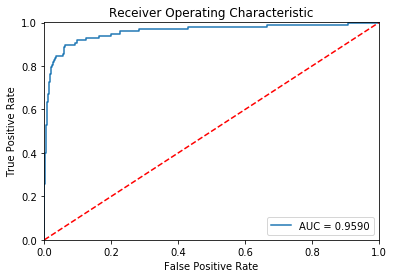

In [149]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [153]:
groups = error_df.groupby('true_class')
groups

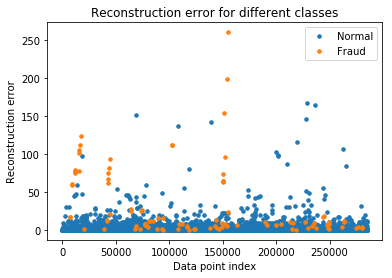

In [154]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
#ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [157]:
error_df[error_df['true_class'] == 1].describe()

,reconstruction_error,true_class
count,98.000000,98.0
mean,30.950587,1.0
std,46.184268,0.0
min,0.156188,1.0
25%,3.974009,1.0
50%,10.034180,1.0
75%,51.324726,1.0
max,260.097222,1.0


In [158]:
error_df[error_df['true_class'] == 0].describe()

,reconstruction_error,true_class
count,56864.000000,56864.0
mean,0.689308,0.0
std,2.589667,0.0
min,0.038702,0.0
25%,0.243365,0.0
50%,0.395077,0.0
75%,0.630639,0.0
max,166.536971,0.0


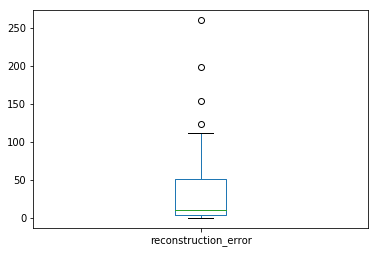

In [164]:
error_df[error_df['true_class'] == 1]['reconstruction_error'].plot(kind= 'box')

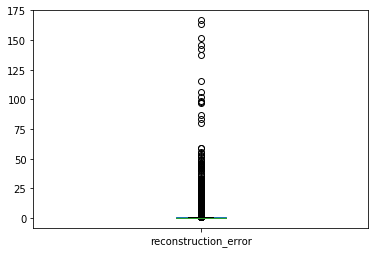

In [163]:
error_df[error_df['true_class'] == 0]['reconstruction_error'].plot(kind= 'box')

### 檢視正常與嫌疑犯交易的重建錯誤

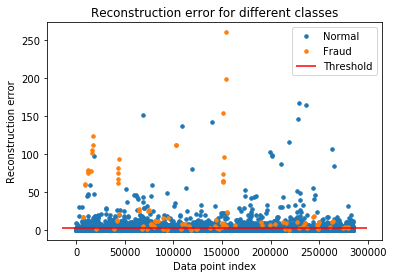

In [159]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(2.9, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

### 檢視Confusion Matrix

In [160]:
y_pred = [1 if e > 2.9 else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
conf_matrix

array([[55555,  1309],
       [   19,    79]], dtype=int64)